In [4]:
# required package import
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

### 데이터 불러오기

In [12]:
# load data
train_df = pd.read_csv('../data/preprocessed_data/train_data.csv')
valid_df = pd.read_csv('../data/preprocessed_data/valid_data.csv')

In [13]:
x_train = train_df.drop(columns = ['cust_no', 'label'])
x_valid = valid_df.drop(columns = ['cust_no', 'label'])
y_train = train_df['label']
y_valid = valid_df['label']

print("x_train.shape: ", x_train.shape)
print("x_valid.shape: ", x_valid.shape)
print("y_train.shape: ", y_train.shape)
print("y_valid.shape: ", y_valid.shape)

x_train.shape:  (125290, 83)
x_valid.shape:  (10000, 83)
y_train.shape:  (125290,)
y_valid.shape:  (10000,)


### I1 결측치 채우기


In [14]:
# data for train
tmp_train = x_train.dropna()
tmp_train_x = tmp_train.drop('I1', axis = 1)
tmp_train_y = tmp_train['I1']

tmp_valid = x_valid.dropna()
tmp_valid_x = tmp_valid.drop('I1', axis = 1)
tmp_valid_y = tmp_valid['I1']

# model training
# (train note)
# logistic regression : no convergence
# random forest(default) : train acc = 1.0 , valid acc = 0.65
# random forest(n_estimators = 100, max_depth = 15) : train acc = 0.77, valid acc = 0.63
# random forest(n_estimators = 500(default), max_depth = 15) : train acc = 0.77, valid acc = 0.64
start_T = time.time()
rf = RandomForestClassifier(max_depth = 15)
rf.fit(tmp_train_x, tmp_train_y)
end_T = time.time()

print("model training time : ", end_T - start_T)

# prediction and evaluation
# train data
tmp_train_pred_y = rf.predict(tmp_train_x)
print('Accuracy: {:.2f}'.format(accuracy_score(tmp_train_y, tmp_train_pred_y)))
print(confusion_matrix(tmp_train_y, tmp_train_pred_y))
print(classification_report(tmp_train_y, tmp_train_pred_y))

# valid data
tmp_valid_pred_y = rf.predict(tmp_valid_x)
print('Accuracy: {:.2f}'.format(accuracy_score(tmp_valid_y, tmp_valid_pred_y)))
print(confusion_matrix(tmp_valid_y, tmp_valid_pred_y))
print(classification_report(tmp_valid_y, tmp_valid_pred_y))

model training time :  38.150205850601196
Accuracy: 0.78
[[60601  7273]
 [20658 36704]]
              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81     67874
         1.0       0.83      0.64      0.72     57362

    accuracy                           0.78    125236
   macro avg       0.79      0.77      0.77    125236
weighted avg       0.79      0.78      0.77    125236

Accuracy: 0.64
[[4169 1270]
 [2297 2261]]
              precision    recall  f1-score   support

         0.0       0.64      0.77      0.70      5439
         1.0       0.64      0.50      0.56      4558

    accuracy                           0.64      9997
   macro avg       0.64      0.63      0.63      9997
weighted avg       0.64      0.64      0.64      9997



In [15]:
# data having null data
x_train.loc[x_train.I1.isna(), 'I1'] = rf.predict(x_train[x_train.I1.isna()].drop('I1', axis = 1))
x_valid.loc[x_valid.I1.isna(), 'I1'] = rf.predict(x_valid[x_valid.I1.isna()].drop('I1', axis = 1))

In [16]:
print("train null data num : ", x_train.isna().sum().sum())
print("valid null data num : ", x_valid.isna().sum().sum())

train null data num :  0
valid null data num :  0


In [17]:
# tmp data save
x_train.to_csv('./tmp_data/x_train.csv', index = None)
x_valid.to_csv('./tmp_data/x_valid.csv', index = None)
y_train.to_csv('./tmp_data/y_train.csv', index = None)
y_valid.to_csv('./tmp_data/y_valid.csv', index = None)

### modeling

In [5]:
x_train = pd.read_csv('./tmp_data/x_train.csv')
x_valid = pd.read_csv('./tmp_data/x_valid.csv')
y_train = pd.read_csv('./tmp_data/y_train.csv')
y_valid = pd.read_csv('./tmp_data/y_valid.csv')

In [12]:
y_train.value_counts()

label
 1.0     80014
 0.0     26133
-1.0     19143
dtype: int64

### SVC modeling

- time complexity : O(n_sample^2 * feature_dim)

#### 1. 기본 데이터

- sampling을 100개를 해서 돌려도 안 돌아가서 차원축소 후에 돌려보려고 함.
- sampling 해도 안 돌아간다.

In [365]:
# DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
y_train = np.array(y_train).ravel()
y_valid = np.array(y_valid).ravel()

In [366]:
# check data shape
print("x_train.shape: ", x_train.shape)
print("x_valid.shape: ", x_valid.shape)
print("y_train.shape: ", y_train.shape)
print("y_valid.shape: ", y_valid.shape)

x_train.shape:  (125290, 83)
x_valid.shape:  (10000, 83)
y_train.shape:  (125290,)
y_valid.shape:  (10000,)


In [367]:
random.seed(2023)
tmp_idx = np.random.choice(np.arange(0,x_train.shape[0]), 100, replace = False)
tmp_x_train = x_train.iloc[tmp_idx]
tmp_y_train = y_train[tmp_idx]
print("tmp_x_train: ", tmp_x_train.shape)
print("tmp_y_train: ", tmp_y_train.shape)

tmp_x_train:  (100, 83)
tmp_y_train:  (100,)


In [ ]:
# model training
# (training note)
# no sampling : 안 돌아감.
# sampling_num = 100 , kernel = linear : time : 안 돌아감.
# sampling_num = 100 , kernel = rbf : time : 안 돌아가겠지..
start_T = time.time()
svc = SVC()
svc.fit(tmp_x_train, tmp_y_train)
end_T = time.time()
print("model training time: ", end_T - start_T)

# prediction and evaluation
# train data
train_pred_y = svc.predict(tmp_x_train)
print('Accuracy: {:.2f}'.format(accuracy_score(y_train, train_pred_y)))
print(confusion_matrix(y_train, train_pred_y))
print(classification_report(y_train, train_pred_y))

# valid data
valid_pred_y = svc.predict(x_valid)
print('Accuracy: {:.2f}'.format(accuracy_score(y_valid, valid_pred_y)))
print(confusion_matrix(y_valid, valid_pred_y))
print(classification_report(y_valid, valid_pred_y))


### DNN modeling

#### 1. 기본 데이터

In [369]:
# check data shape
print("x_train.shape: ", x_train.shape)
print("x_valid.shape: ", x_valid.shape)
print("y_train.shape: ", y_train.shape)
print("y_valid.shape: ", y_valid.shape)

x_train.shape:  (125290, 83)
x_valid.shape:  (10000, 83)
y_train.shape:  (125290, 1)
y_valid.shape:  (10000, 1)


In [370]:
class2idx = {-1:0, 0:1, 1:2}
idx2class = {v: k for k, v, in class2idx.items()}

y_train.replace(class2idx, inplace = True)
y_valid.replace(class2idx, inplace = True)

In [371]:
x_train = x_train.astype('float32')
x_train = x_train.astype('float32')
y_train = y_train.astype('int')
y_valid = y_valid.astype('int')

##### data loader

In [372]:
tensor_train_x = torch.Tensor(x_train.values)
tensor_train_y = torch.Tensor(y_train.values.reshape(-1))
tensor_valid_x = torch.Tensor(x_valid.values)
tensor_valid_y = torch.Tensor(y_valid.values.reshape(-1))

In [373]:
train_data = TensorDataset(tensor_train_x, tensor_train_y)
valid_data = TensorDataset(tensor_valid_x, tensor_valid_y)

In [388]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True, drop_last = True)
valid_loader = DataLoader(valid_data, batch_size = 64, shuffle = True, drop_last = True)

##### required function

In [445]:
# training
def train(model, train_loader, optimizer, i_epoch, device):
    accurate = 0
    for i, (feature, target) in enumerate(train_loader):
        feature = feature.to(device)
        output = model(feature)
        target = target.type(torch.int64)
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        prediction = torch.argmax(output, dim = 1)
        accurate += prediction.eq(target.view_as(prediction)).sum().item()

        loss_value.append(loss.detach().numpy())

        if i%100 == 0:
            print("epoch: {}, iteration: {}, loss: {}".format(i_epoch, i, loss.item()))
    accuracy = accurate / len(train_loader.dataset)
    train_accuracy_value.append(accuracy)

In [446]:
# test
def test(model, test_loader, i_epoch, device):
    model.eval()
    accurate = 0
    test_loss = 0

    with torch.no_grad():
        for i, (feature, target) in enumerate(test_loader):
            feature = feature.to(device)
            output = model(feature)
            target = target.type(torch.int64)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            prediction = torch.argmax(output, dim=1)
            accurate += prediction.eq(target.view_as(prediction)).sum().item()
    accuracy = accurate / len(test_loader.dataset)
    test_accuracy_value.append(accuracy)
    print("epoch: {},train_accuracy:{}, test_accuracy: {}".format(i_epoch, train_accuracy_value[i_epoch], test_accuracy_value[i_epoch]))

##### modeling

In [570]:
_, n_feature = x_train.shape

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_feature, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.reshape(-1, n_feature)
        return self.fc(x)

##### evaluation

In [571]:
loss_value = []
train_accuracy_value = []
test_accuracy_value = []
model = net()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [572]:
for i_epoch in range(20):
    train(model, train_loader, optimizer, i_epoch, device)
    test(model, valid_loader, i_epoch, device)


epoch: 0, iteration: 0, loss: 1.1082524061203003
epoch: 0, iteration: 100, loss: 1.1234849691390991
epoch: 0, iteration: 200, loss: 1.1295756101608276
epoch: 0, iteration: 300, loss: 1.1296627521514893
epoch: 0, iteration: 400, loss: 0.9890377521514893
epoch: 0, iteration: 500, loss: 1.0143674612045288
epoch: 0, iteration: 600, loss: 1.0417503118515015
epoch: 0, iteration: 700, loss: 1.0067987442016602
epoch: 0, iteration: 800, loss: 1.0574581623077393
epoch: 0, iteration: 900, loss: 1.0897666215896606
epoch: 0, iteration: 1000, loss: 0.9781778454780579
epoch: 0, iteration: 1100, loss: 0.9814689755439758
epoch: 0, iteration: 1200, loss: 0.8877189755439758
epoch: 0, iteration: 1300, loss: 0.9801355600357056
epoch: 0, iteration: 1400, loss: 0.9264506101608276
epoch: 0, iteration: 1500, loss: 0.9512869715690613
epoch: 0, iteration: 1600, loss: 1.0057307481765747
epoch: 0, iteration: 1700, loss: 0.9188817739486694
epoch: 0, iteration: 1800, loss: 0.9873893857002258
epoch: 0, iteration: 190

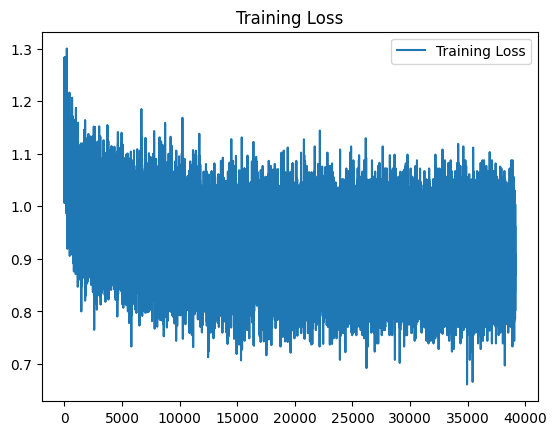

In [573]:
#그래프 확인
plt.plot(loss_value, label='Training Loss')
plt.title('Training Loss')
plt.legend()

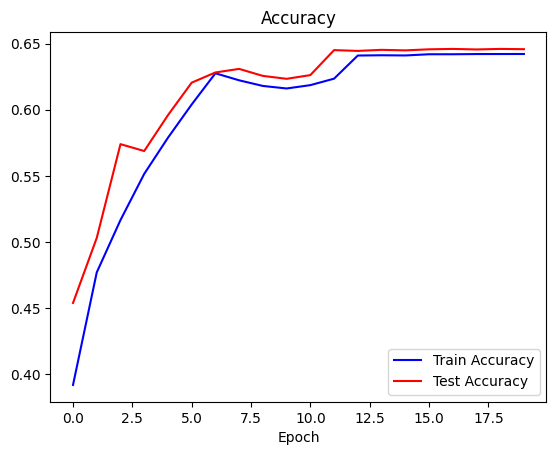

In [574]:
plt.plot(train_accuracy_value, label='Train Accuracy', c = 'b')
plt.plot(test_accuracy_value, label='Test Accuracy', c= 'r')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [575]:
len(train_accuracy_value)

20

In [576]:
print(test_accuracy_value[-1])

0.6458


In [577]:

print('====================================================')
print("Model's state_dict for epoch :", i_epoch)
for param_tensor in model.state_dict():
  print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("train acc : ", train_accuracy_value[-1] , "test acc: ", test_accuracy_value[-1])

print('====================================================')


Model's state_dict for epoch : 19
fc.0.weight 	 torch.Size([16, 83])
fc.0.bias 	 torch.Size([16])
fc.2.weight 	 torch.Size([3, 16])
fc.2.bias 	 torch.Size([3])
train acc :  0.6421661744752175 test acc:  0.6458


In [ ]:
# train note
'''
====================================================
# Model's state_dict for epoch : 9
# fc.0.weight 	 torch.Size([32, 83])
# fc.0.bias 	 torch.Size([32])
# fc.2.weight 	 torch.Size([3, 32])
# fc.2.bias 	 torch.Size([3])
# train acc :  0.6476494532684173 test acc:  0.655
====================================================
'''
'''
====================================================
Model's state_dict for epoch : 19
fc.0.weight 	 torch.Size([16, 83])
fc.0.bias 	 torch.Size([16])
fc.2.weight 	 torch.Size([3, 16])
fc.2.bias 	 torch.Size([3])
train acc :  0.6568361401548408 test acc:  0.6659
====================================================
,,,
====================================================
Model's state_dict for epoch : 19
fc.0.weight 	 torch.Size([32, 83])
fc.0.bias 	 torch.Size([32])
fc.2.weight 	 torch.Size([32, 32])
fc.2.bias 	 torch.Size([32])
fc.4.weight 	 torch.Size([32, 32])
fc.4.bias 	 torch.Size([32])
fc.6.weight 	 torch.Size([3, 32])
fc.6.bias 	 torch.Size([3])
train acc :  0.6598212147817064 test acc:  0.6682
====================================================
'''
'''
====================================================
Model's state_dict for epoch : 19
fc.0.weight 	 torch.Size([16, 83])
fc.0.bias 	 torch.Size([16])
fc.2.weight 	 torch.Size([16, 16])
fc.2.bias 	 torch.Size([16])
fc.4.weight 	 torch.Size([16, 16])
fc.4.bias 	 torch.Size([16])
fc.6.weight 	 torch.Size([3, 16])
fc.6.bias 	 torch.Size([3])
train acc :  0.6593103998722962 test acc:  0.6634
====================================================
'''
'''
====================================================
Model's state_dict for epoch : 19
fc.0.weight 	 torch.Size([16, 83])
fc.0.bias 	 torch.Size([16])
fc.2.weight 	 torch.Size([16, 16])
fc.2.bias 	 torch.Size([16])
fc.4.weight 	 torch.Size([3, 16])
fc.4.bias 	 torch.Size([3])
train acc :  0.6694867906457019 test acc:  0.6759
====================================================
'''
'''
====================================================
Model's state_dict for epoch : 19
fc.0.weight 	 torch.Size([8, 83])
fc.0.bias 	 torch.Size([8])
fc.2.weight 	 torch.Size([8, 8])
fc.2.bias 	 torch.Size([8])
fc.4.weight 	 torch.Size([3, 8])
fc.4.bias 	 torch.Size([3])
train acc :  0.6532604357889696 test acc:  0.6633
====================================================
'''
'''
====================================================
Model's state_dict for epoch : 19
fc.0.weight 	 torch.Size([8, 83])
fc.0.bias 	 torch.Size([8])
fc.2.weight 	 torch.Size([3, 8])
fc.2.bias 	 torch.Size([3])
train acc :  0.6157394843962009 test acc:  0.6255
====================================================
'''

### adaboost

In [6]:
y_train = np.array(y_train).ravel()
y_valid = np.array(y_valid).ravel()

In [7]:
# check data shape
print("x_train.shape: ", x_train.shape)
print("x_valid.shape: ", x_valid.shape)
print("y_train.shape: ", y_train.shape)
print("y_valid.shape: ", y_valid.shape)

x_train.shape:  (125290, 83)
x_valid.shape:  (10000, 83)
y_train.shape:  (125290,)
y_valid.shape:  (10000,)


In [ ]:
# train note
# model training time:  20.83764910697937

start_T = time.time()
adaboost = AdaBoostClassifier()
adaboost.fit(x_train, y_train)
end_T = time.time()
print("model training time: ", end_T - start_T)

# prediction and evaluation
# train data
train_pred_y = adaboost.predict(x_train)
print('Accuracy: {:.2f}'.format(accuracy_score(y_train, train_pred_y)))
print(confusion_matrix(y_train, train_pred_y))
print(classification_report(y_train, train_pred_y))

# valid data
valid_pred_y = adaboost.predict(x_valid)
print('Accuracy: {:.2f}'.format(accuracy_score(y_valid, valid_pred_y)))
print(confusion_matrix(y_valid, valid_pred_y))
print(classification_report(y_valid, valid_pred_y))

In [8]:
# optuna로 최적화해보기
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score
import plotly

In [9]:
def objectAdaboost(trial : Trial, x_train, y_train, x_test, y_test):
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate' : round(trial.suggest_float('learning_rate', 0.1, 3.0), 3),
    }

    adaboost = AdaBoostClassifier(**param)
    adaboost.fit(x_train, y_train)

    score = f1_score(adaboost.predict(x_test), y_test, average = 'micro')

    return score

In [ ]:
study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
study.optimize(lambda trial : objectAdaboost(trial, x_train, y_train, x_valid, y_valid), n_trials = 10)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))


[I 2023-01-29 16:38:05,702] A new study created in memory with name: no-name-ba571969-26fd-4cab-908e-748f29ce285a


In [ ]:
optuna.visualization.plot_param_importances(study) # 파라미터 중요도 확인 그래프
optuna.visualization.plot_optimization_history(study) # 최적화 과정 시각화